In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

bq = bigquery.Client(project='gcp-wow-rwds-ai-mmm-prod')


In [5]:
# load dataset
df = bq.query("SELECT * FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM.MMM_METRIC_OFFERTYPE`").result().to_dataframe()
df.head()


offer_type       campaign_start_date   roc_auc  allocation       rdm  \
0         2C 2021-07-19 00:00:00+00:00  0.969740      433216  0.007447   
1         2C 2021-08-02 00:00:00+00:00  0.951985      349076  0.013963   
2         2C 2021-03-01 00:00:00+00:00  0.940202      887819  0.027977   
3         2C 2021-01-18 00:00:00+00:00  0.940278      972096  0.026224   
4         2C 2021-01-04 00:00:00+00:00  0.923697      785690  0.015655   

   rdm_pred        spd   spd_pred       smape   base_spd      cost  cost_pred  
0  0.013007  32.828894  30.589726  124.430925  34.026553  0.224366   0.356768  
1  0.017400  47.101786  44.751326  111.986452  45.663006  0.419535   0.496258  
2  0.034795  65.789341  70.471153   87.765989  64.173227  0.905575   1.216506  
3  0.030358  63.202226  64.149538   96.529945  59.832791  0.865040   1.096681  
4  0.018322  56.345406  58.172040  100.109658  53.711567  0.533570   0.659611

In [191]:
offer_types = list(set(df.offer_type.unique()))
offer_types.sort()
offer_types = [offer_type for offer_type in offer_types if offer_type != 'ALL']

In [8]:
df_agg = df.groupby(['offer_type','campaign_start_date']).aggregate({'allocation':'sum'}).reset_index()

In [12]:
df_allocation = df_agg.pivot(index='campaign_start_date', columns='offer_type', values='allocation').reset_index().fillna(0)

In [27]:
offer_types = list(df_allocation.columns[1:])
offer_types = [offer_type for offer_type in offer_types if offer_type != 'ALL']

In [34]:
offer_types + ['campaign_start_date']

['2C',
 '4C',
 'DNS',
 'MP1',
 'MP3',
 'RA',
 'SGU',
 'SS1',
 'SS2',
 'TMP',
 'campaign_start_date']

In [116]:
df['campaign_start_date'].apply(lambda x: x.date())

0      2021-07-19
1      2021-08-02
2      2021-03-01
3      2021-01-18
4      2021-01-04
          ...    
154    2021-08-16
155    2021-08-30
156    2021-09-13
157    2021-09-27
158    2021-10-11
Name: campaign_start_date, Length: 159, dtype: object

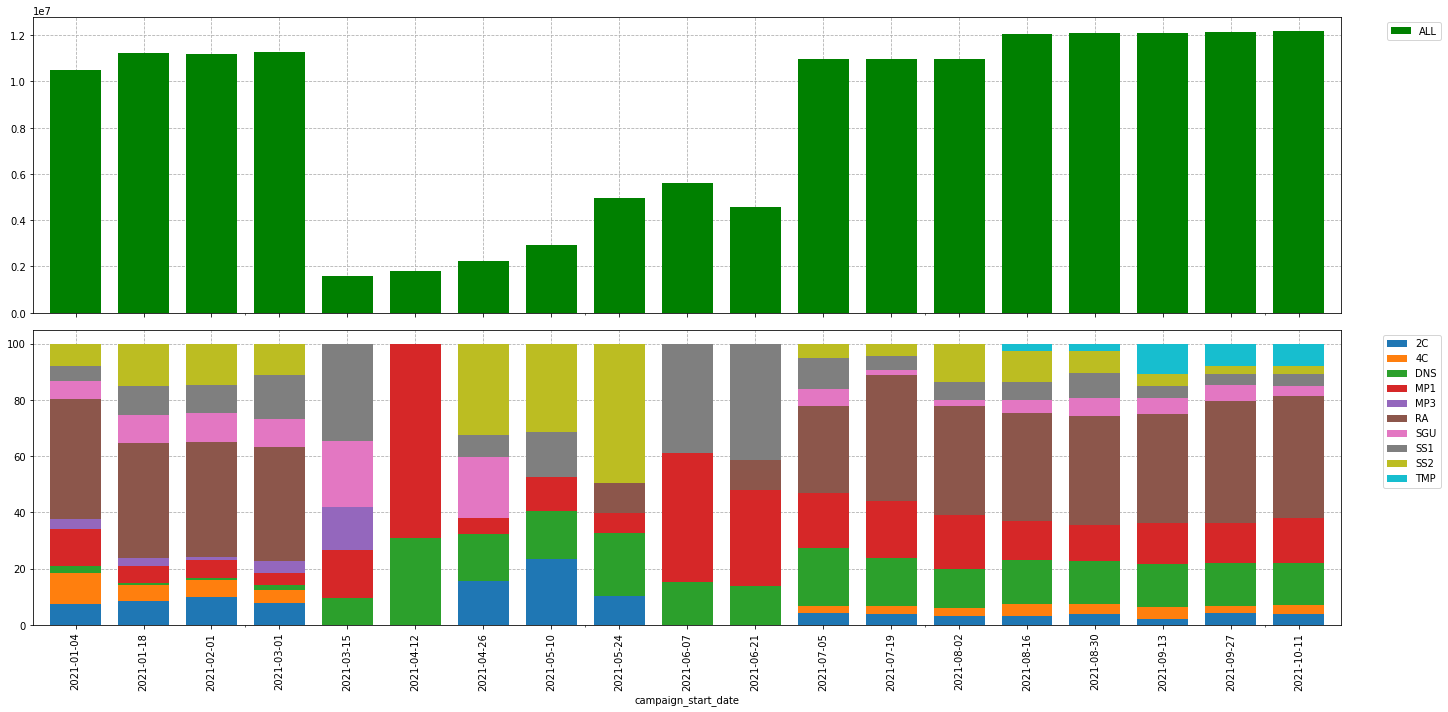

In [105]:
# plot a Stacked Bar Chart using matplotlib


df_rel = df_allocation.copy()
for offer_type in offer_types:
    df_rel[offer_type] = df_allocation[offer_type].div(df_allocation['ALL'], 0)*100
df_rel.drop(columns='ALL', inplace=True)
df_rel['campaign_start_date'] = df_rel['campaign_start_date'].apply(lambda x: x.date())

fig, ax = plt.subplots(2, 1, figsize = (20,10), sharex=True)


ax[0].grid(linestyle='dashed')
df_allocation[['campaign_start_date', 'ALL']].plot(
    x ='campaign_start_date',
    kind = 'bar', 
    width = 0.75,
    ax = ax[0],
    color = 'green'
)
df_rel.plot(
    x ='campaign_start_date',
    kind = 'bar', 
    width = 0.75,
    stacked = True, 
    ax = ax[1],
)

for i in range(2):
    ax[i].set_axisbelow(True)
    ax[i].legend(bbox_to_anchor=(1.08, 1))
    ax[i].grid(linestyle='dashed')
fig.tight_layout()
plt.show()





  
# for n in df_rel:
#     for i, (cs, ab, pc) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], 
#                                          df[n], df_rel[n])):
#         plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
#                  va = 'center', ha = 'center')

In [159]:
df_offer_type = df[df.offer_type == offer_type]

In [161]:
df_offer_type[['offer_type', 'smape']]

offer_type       smape
154        TMP  145.839513
155        TMP  147.310100
156        TMP   85.976711
157        TMP   85.400735
158        TMP   84.286968

In [176]:
df_dates = pd.DataFrame({'campaign_start_date':(list(set(df.campaign_start_date.unique())))})
df_dates.sort_values('campaign_start_date').reset_index(drop=True)

campaign_start_date
0           2021-01-04
1           2021-01-18
2           2021-02-01
3           2021-03-01
4           2021-03-15
5           2021-04-12
6           2021-04-26
7           2021-05-10
8           2021-05-24
9           2021-06-07
10          2021-06-21
11          2021-07-05
12          2021-07-19
13          2021-08-02
14          2021-08-16
15          2021-08-30
16          2021-09-13
17          2021-09-27
18          2021-10-11

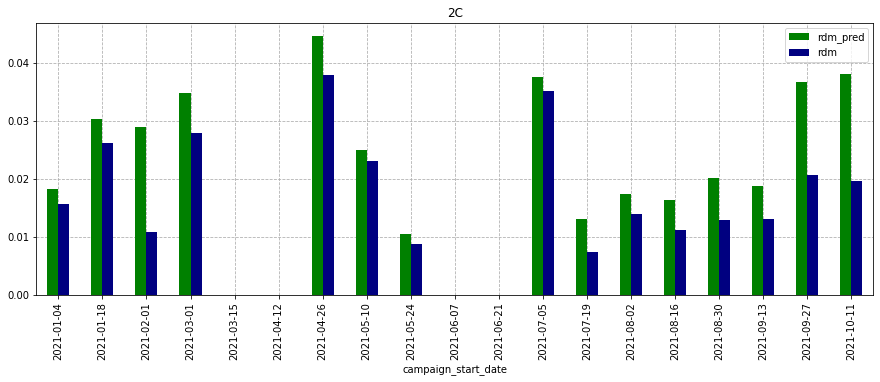

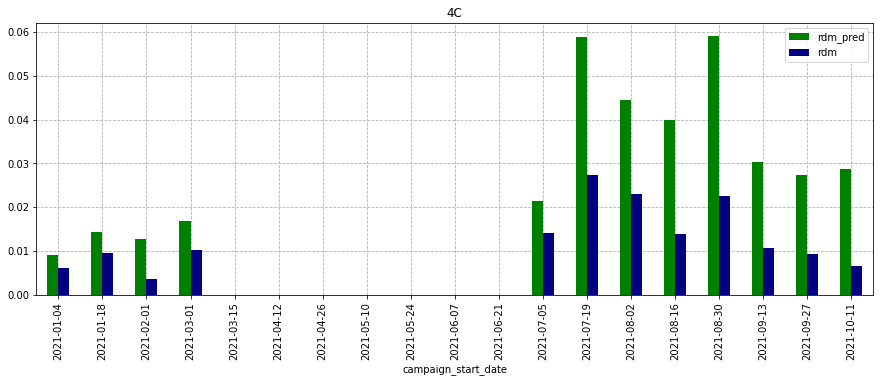

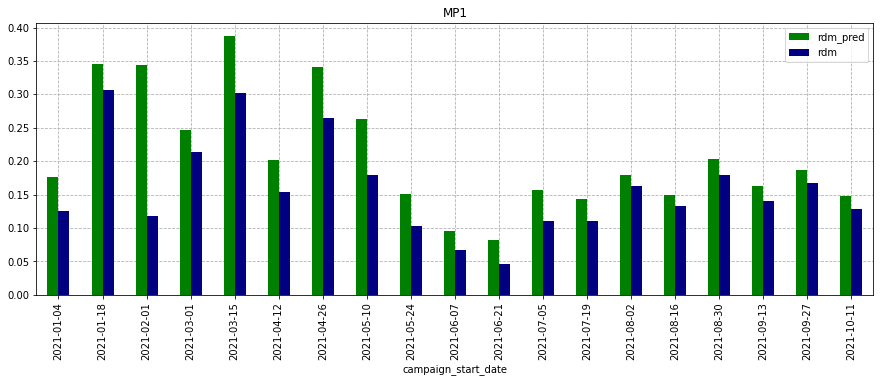

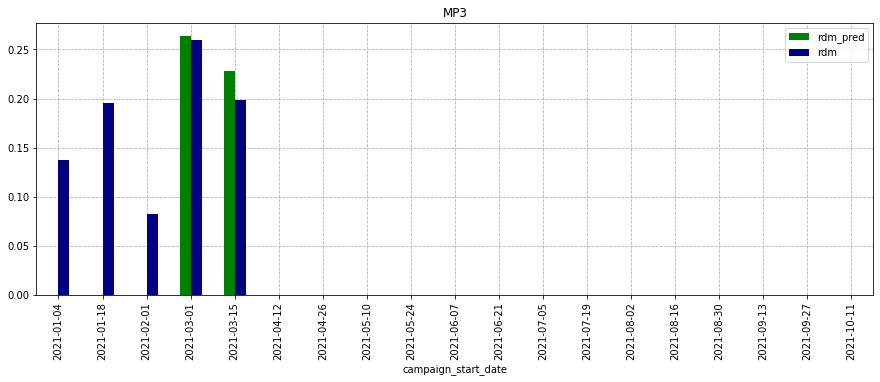

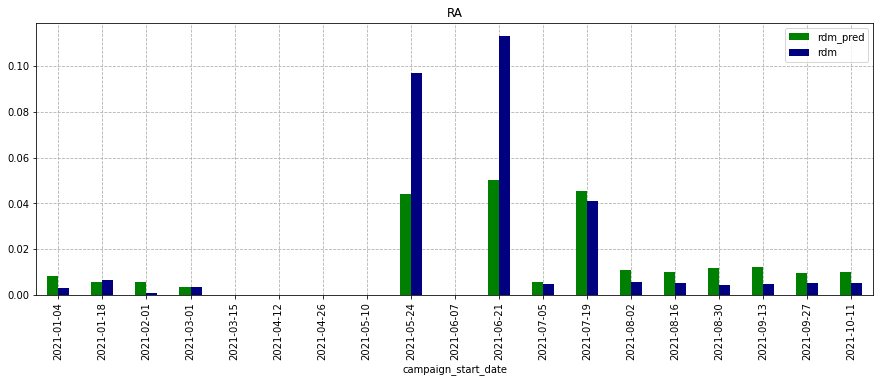

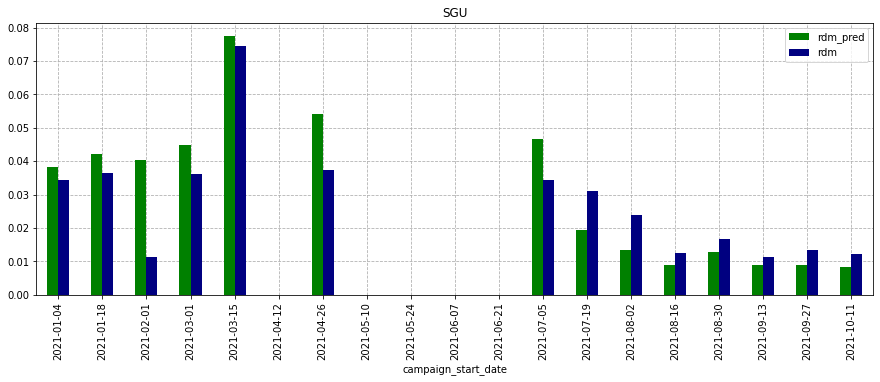

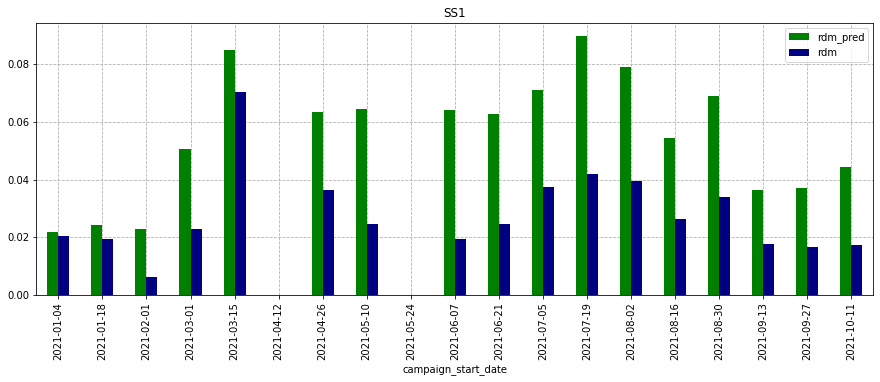

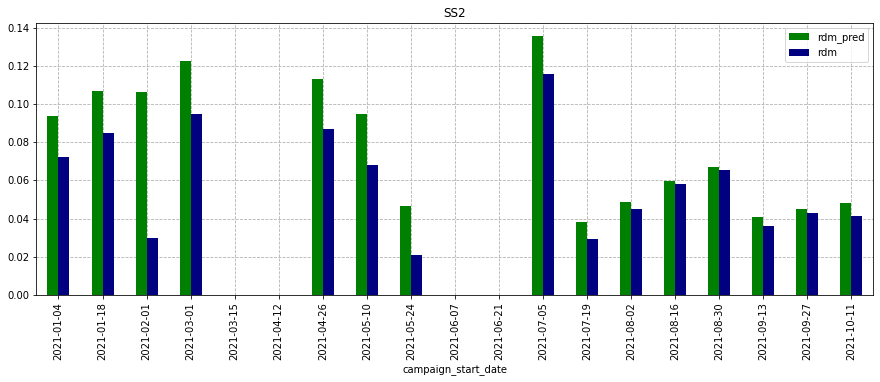

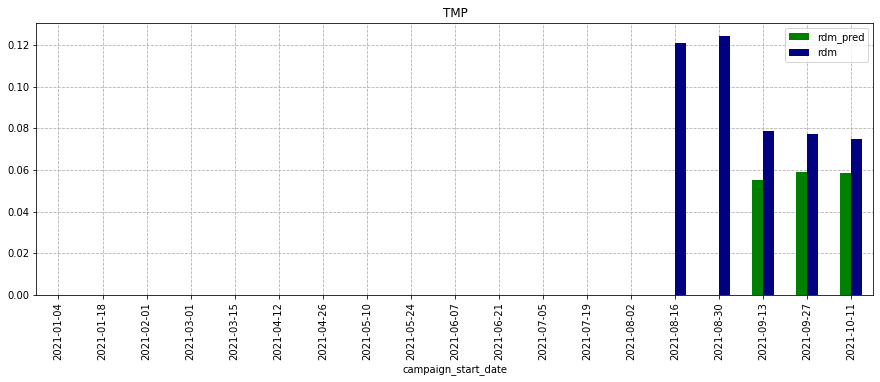

In [199]:
metric = ['rdm', 'rdm_pred']
for offer_type in offer_types:
    if offer_type != 'DNS':
        df_offer_type = df[df.offer_type == offer_type][['campaign_start_date', 'rdm_pred', 'rdm']]
        df_offer_type = df_dates.merge(df_offer_type, how='left', left_on='campaign_start_date', right_on='campaign_start_date')
        df_offer_type = df_offer_type.sort_values('campaign_start_date').reset_index(drop=True)
        fig, ax = plt.subplots(figsize=(15,5))
        df_offer_type.plot(
            x ='campaign_start_date',
            kind = 'bar', 
            stacked = False, 
            ax = ax,
            legend=True,
            color=['green', 'navy'],
        )
        ax.set_title(offer_type)
        ax.set_axisbelow(True)
        plt.grid(linestyle='dashed')